Re-running the graph witness notebook with refractored code

In [1]:
import qcdenoise as qcd
import matplotlib.pyplot as plt
import qiskit as qk
import numpy as np
import networkx as nx

import os

Global seed set to 1234


In [2]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### 1. Building Quantum Circuit from Graph States Database


#### Load the default graph state database

This is the corpus from which subgraphs are drawn and combined to form random graphs

qcdenoise.graph_data- 06/15/2021 11:42:05 - INFO - Building database with Graphs from Hein et al. 


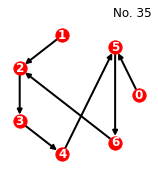

{'G': <networkx.classes.digraph.DiGraph at 0x134ab93a0>,
 'V': 7,
 'LUclass': None,
 '2Color': None}

In [3]:
graph_db = qcd.GraphDB(directed=True)
graph_db.plot_graph(graph_number=[35])
graph_db['35']

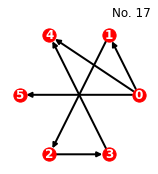

{'G': <networkx.classes.digraph.DiGraph at 0x134a72ca0>,
 'V': 6,
 'LUclass': None,
 '2Color': None}

In [4]:
graph_db.plot_graph(graph_number=[17])
graph_db['17']

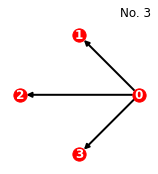

{'G': <networkx.classes.digraph.DiGraph at 0x108fc7d30>,
 'V': 4,
 'LUclass': None,
 '2Color': None}

In [5]:
graph_db.plot_graph(graph_number=[3])
graph_db['3']

#### Initiate a q-circuit builder from graph states

Build a random graph on 4 qubits with undirected edges

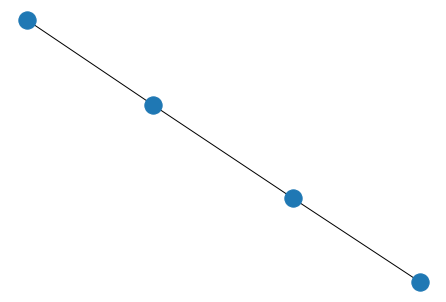

In [6]:
n_qubits=4
graph_state = qcd.GraphState(graph_db=graph_db, n_qubits=n_qubits)
g = graph_state.sample()
nx.draw(g)

In [7]:
circ_builder = qcd.CXGateCircuit(n_qubits=n_qubits,stochastic=True)

In [8]:
circ_builder.stochastic

True

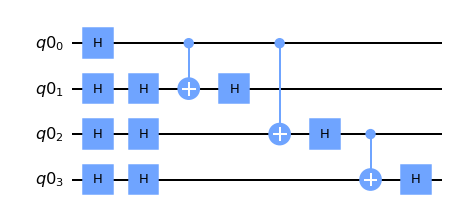

In [9]:
circ_builder.build(g)["circuit"].draw(output='mpl')

In [10]:
base_circuit = circ_builder.circuit

Once the circuit builder is initialized, and the base circuit is constructed- then the generators and stabilizer operators can be built

Calling `TothStabilizer` or `JungStabilizer` will build the sub-circuits needed to measure each stabilizer (Pauli string)

**Note** the generators and stabilizers will depend on the neighborhoods of each vertex and what is defined as a neighbor is dependent on the `NetworkX` graph structure.  If the edges are directed (pass `directed=True` inside `GraphConstructor`) then only vertices connected by a directed arc that ternminates at vertex (i) is a neighbor of (i).  On the other hand, if the graph is undirected (the default is `directed=False`) then any vertex connected by an edge to vertex (i) is a neighbor.

In [11]:
stabilizer = qcd.TothStabilizer(g, n_qubits=n_qubits)

In [12]:
stab_ops = stabilizer.find_stabilizers()

In [13]:
stabilizer_circuit_dict = stabilizer.build()

In [14]:
stabilizer_circuit_dict

OrderedDict([('IZZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d274c0>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27640>),
             ('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27a90>),
             ('ZXIZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27cd0>),
             ('IIXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27460>)])

The keys of the `circuit_dict` are the associated Pauli strings to measure-- comparing the keys to the graph `g` above, they are correctly defined

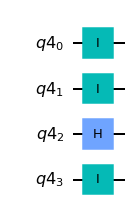

In [15]:
stabilizer_circuit_dict['ZXIZ'].draw(output='mpl')

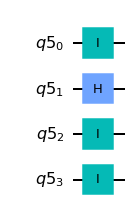

In [16]:
stabilizer_circuit_dict['IIXZ'].draw(output='mpl')

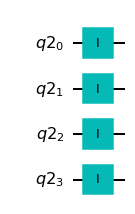

In [17]:
stabilizer_circuit_dict['IIII'].draw(output='mpl')

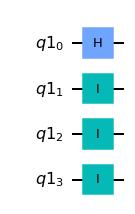

In [18]:
stabilizer_circuit_dict['IZZX'].draw(output='mpl')

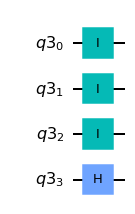

In [19]:
stabilizer_circuit_dict['XZII'].draw(output='mpl')

_there is something wrong with the stabilizer construction the initial Pauli operator is being dropped_

**Current Workaround** when the stabilizer strings are built using `find_stabilizers` followed by `get_unique_stabilizers`, the leading sign coefficient is dropped, using `drop_coef=True` will then result in a Pauli operator getting dropped.  Current workaround sets the default value of `drop_coef=False`.

Stabilizer stubs are correctly built with this workaround

In [20]:
stabilizer_circuit_dict

OrderedDict([('IZZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d274c0>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27640>),
             ('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27a90>),
             ('ZXIZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27cd0>),
             ('IIXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27460>)])

##### Build and mesure stabilizer circuits

pass the dictionary of stabilier sub-circuits and the base circuit

In [21]:
from qiskit.test.mock import FakeValencia

In [22]:
sampler = qcd.StabilizerSampler(
        backend=FakeValencia(), n_shots=1024)

In [23]:
counts = sampler.sample(stabilizer_circuits=stabilizer_circuit_dict,
                            graph_circuit=base_circuit)

qcdenoise.samplers- 06/15/2021 11:42:07 - INFO - Transpiling circuit and generating the circuit DAG
qcdenoise.samplers- 06/15/2021 11:42:07 - INFO - Simulating Circuit on AerSimulator


In [24]:
counts

[{'1011': 114,
  '0101': 148,
  '1101': 120,
  '1000': 123,
  '1110': 133,
  '0011': 138,
  '0110': 138,
  '0000': 110},
 {'0000': 62,
  '0110': 59,
  '0111': 61,
  '1010': 68,
  '1001': 69,
  '1011': 56,
  '1100': 73,
  '0100': 75,
  '1110': 69,
  '1000': 62,
  '0001': 66,
  '0011': 62,
  '0101': 66,
  '0010': 53,
  '1111': 59,
  '1101': 64},
 {'0011': 127,
  '1111': 128,
  '0000': 139,
  '0010': 122,
  '1101': 122,
  '1100': 130,
  '1110': 138,
  '0001': 118},
 {'1001': 131,
  '0111': 131,
  '1110': 138,
  '1100': 120,
  '1011': 127,
  '0101': 137,
  '0000': 118,
  '0010': 122},
 {'0000': 115,
  '1011': 127,
  '0011': 136,
  '0111': 133,
  '1111': 123,
  '1000': 119,
  '1100': 152,
  '0100': 119}]

#### Extract the expectation values from the counts
Use the built-in Qiskit functions of `ignis`.  when `Witness` is constructed, the diagonals and expectation values are evaluated and storedd.  Calling `evaluate()` constructs the witness value from these stored values  

In [25]:
witness = qcd.GenuineWitness(n_qubits=n_qubits,stabilizer_circuits=stabilizer_circuit_dict,stabilizer_counts=counts)

In [26]:
witness.stabilizer_circuits

OrderedDict([('IZZX',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d274c0>),
             ('IIII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27640>),
             ('XZII',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27a90>),
             ('ZXIZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27cd0>),
             ('IIXZ',
              <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x134d27460>)])

In [27]:
witness.stabilizer_counts

[{'1011': 114,
  '0101': 148,
  '1101': 120,
  '1000': 123,
  '1110': 133,
  '0011': 138,
  '0110': 138,
  '0000': 110},
 {'0000': 62,
  '0110': 59,
  '0111': 61,
  '1010': 68,
  '1001': 69,
  '1011': 56,
  '1100': 73,
  '0100': 75,
  '1110': 69,
  '1000': 62,
  '0001': 66,
  '0011': 62,
  '0101': 66,
  '0010': 53,
  '1111': 59,
  '1101': 64},
 {'0011': 127,
  '1111': 128,
  '0000': 139,
  '0010': 122,
  '1101': 122,
  '1100': 130,
  '1110': 138,
  '0001': 118},
 {'1001': 131,
  '0111': 131,
  '1110': 138,
  '1100': 120,
  '1011': 127,
  '0101': 137,
  '0000': 118,
  '0010': 122},
 {'0000': 115,
  '1011': 127,
  '0011': 136,
  '0111': 133,
  '1111': 123,
  '1000': 119,
  '1100': 152,
  '0100': 119}]

In [28]:
witness.diagonals

OrderedDict([('IZZX',
              array([ 1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,
                      1.,  1., -1.])),
             ('IIII',
              array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
             ('XZII',
              array([ 1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
                      1.,  1.,  1.])),
             ('ZXIZ',
              array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
                     -1.,  1., -1.])),
             ('IIXZ',
              array([ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
                     -1., -1.,  1.]))])

In [29]:
witness.stabilizer_measurements

OrderedDict([('IZZX', (1.0, 0.0)),
             ('IIII', (1.0, 0.0)),
             ('XZII', (1.0, 0.0)),
             ('ZXIZ', (1.0, 0.0)),
             ('IIXZ', (1.0, 0.0))])

#### Construct the witness value by hand using the stored values

In [30]:
non_iden_keys = [x for x in witness.stabilizer_measurements if x!='IIII']
genuine_wit = (n_qubits-1)*witness.stabilizer_measurements['IIII'][0]-\
                    np.sum([witness.stabilizer_measurements[kdx][0] for kdx in non_iden_keys])

In [31]:
genuine_wit

-1.0

#### Construct the witness value using `.estimate()`

In [32]:
witness.estimate(graph=g,noise_robust= 0)

Witness(W_ij=None, value=-1.0, variance=array(0.))